In [1]:
# !pwd
# import os
# os.chdir("drive/klab2class")
# !ls

/content
match.ipynb  test_set.csv  train_set.csv  Untitled.ipynb


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate, GridSearchCV

%matplotlib inline

In [2]:
train_data = pd.read_csv('./train_set.csv')
test_data = pd.read_csv('./test_set.csv')

train_data.drop(['ID'], axis=1, inplace=True)
test_data.drop(['ID'], axis=1, inplace=True)

train_data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
1,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
2,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
3,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
4,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0
5,56,services,divorced,secondary,no,450,no,no,unknown,9,jun,47,1,-1,0,unknown,0
6,32,management,single,tertiary,no,1716,no,no,cellular,21,nov,157,4,-1,0,unknown,0
7,33,management,single,tertiary,no,-359,no,no,telephone,29,aug,59,2,-1,0,unknown,0
8,32,technician,single,secondary,no,309,yes,yes,cellular,25,aug,99,3,-1,0,unknown,0
9,55,management,married,tertiary,no,4777,no,yes,unknown,20,jun,12,3,-1,0,unknown,0


# 一、快速进行数据分析
从简单的分析可以看出，基本数据还是比较完整的，没有什么空值。文本类基本都是类型，类型数量也不太多，不需要做聚合和转换

In [0]:
train_data.info()
# train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 17 columns):
age          25317 non-null int64
job          25317 non-null object
marital      25317 non-null object
education    25317 non-null object
default      25317 non-null object
balance      25317 non-null int64
housing      25317 non-null object
loan         25317 non-null object
contact      25317 non-null object
day          25317 non-null int64
month        25317 non-null object
duration     25317 non-null int64
campaign     25317 non-null int64
pdays        25317 non-null int64
previous     25317 non-null int64
poutcome     25317 non-null object
y            25317 non-null int64
dtypes: int64(8), object(9)
memory usage: 3.3+ MB


In [0]:
train_data['poutcome'].value_counts()

unknown    20677
failure     2735
other       1070
success      835
Name: poutcome, dtype: int64

In [0]:
corr_matrix = train_data.corr()

In [0]:
corr_matrix['y'].sort_values()

campaign   -0.075173
day        -0.031886
age         0.029916
balance     0.057564
previous    0.088337
pdays       0.107565
duration    0.394746
y           1.000000
Name: y, dtype: float64

# 二、数据的深入分析

1、关于月份和日期
组合起来看看月份和日期对最终结果的影响，可以通过散点图看看结果。
从结果可以看出日期对最终结果没有太大的影响，这个特征可以去除

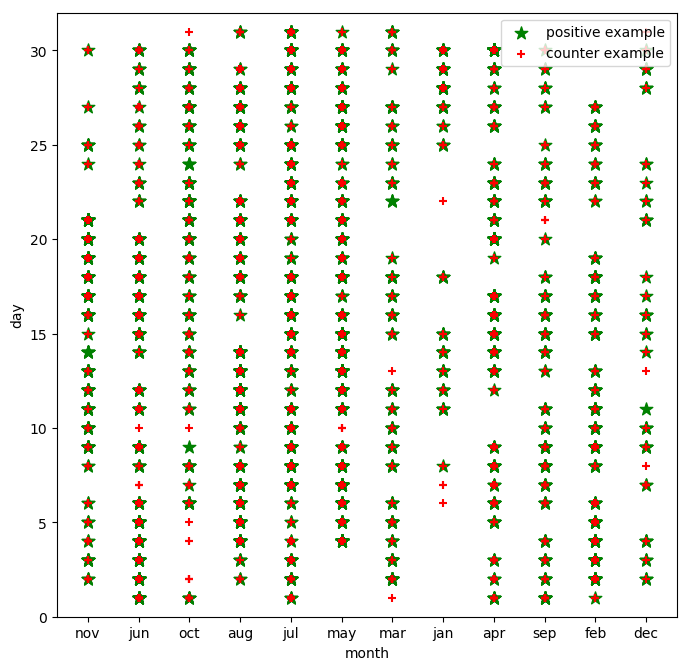

In [0]:
x1 = train_data[train_data['y'] == 1]['month']
y1 = train_data[train_data['y'] == 1]['day']
x0 = train_data[train_data['y'] == 0]['month']
y0 = train_data[train_data['y'] == 0]['day']

# figsize:指定figure的宽和高，单位为英寸；dpi参数指定绘图对象的分辨率
plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(x1, y1, marker='*', color='green', s=90, label='positive example')
plt.legend(loc='best')
plt.scatter(x0, y0, marker='+', color='red', s=30, label='counter example',)
plt.ylim((0, 32))
plt.xlabel('month')
plt.ylabel('day')
plt.legend(loc='best')
plt.show()

2、对几个和贷款、房贷有关的特征组合进行一下分析
在这里可以对"default","housing","loan"，基于pandas做透视图pivot_table

In [0]:
aa = pd.pivot_table(train_data,index=["default","housing","loan"],columns=["y"],values=["age"],aggfunc=np.size)
aa = aa.reset_index()

In [0]:
aa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
(default, )    8 non-null object
(housing, )    8 non-null object
(loan, )       8 non-null object
(age, 0)       8 non-null int64
(age, 1)       8 non-null int64
dtypes: int64(2), object(3)
memory usage: 400.0+ bytes


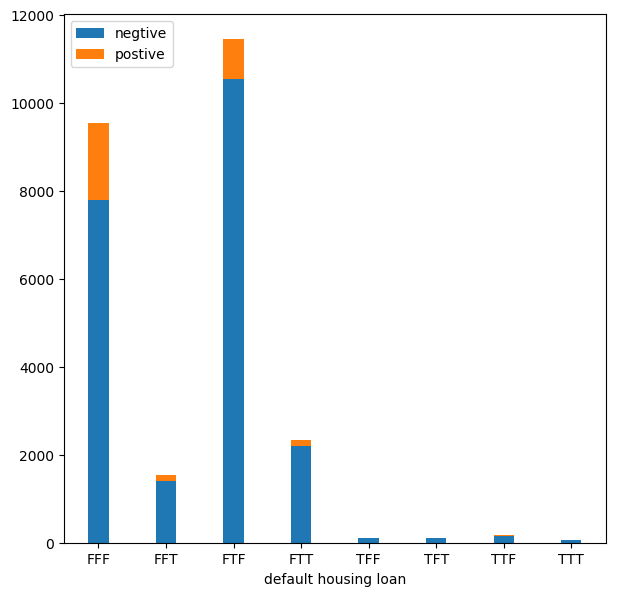

In [0]:
# aa = aa.reset_index()
y_1 = aa['age',1]
y_0 = aa['age',0]
x = ['FFF', 'FFT', 'FTF', 'FTT', 'TFF', 'TFT', 'TTF', 'TTT']
plt.figure(figsize=(7, 7), dpi=100)
plt.bar(x, y_0, width=0.3)
plt.bar(x, y_1, width=0.3, bottom=y_0)
plt.xlabel('default housing loan')
plt.legend(['negtive', 'postive'], loc='upper left')
plt.show()

In [0]:
aa

default housing loan    age      
y                           0     1
0      no      no   no   7782  1762
1      no      no  yes   1412   128
2      no     yes   no  10542   901
3      no     yes  yes   2198   144
4     yes      no   no     96     8
5     yes      no  yes    105     4
6     yes     yes   no    157    10
7     yes     yes  yes     64     4

2、对几个分类类型的数据对最终结果的影响程度做一下判断
探讨【客户的职业】、【婚姻状况】、【受教育水平】、【与客户联系的沟通方式】、【上一次活动的结果】与客户是否会订购定期存款业务的联系
从结果来看，似乎婚姻的影响不大，可以删除，也可以保留

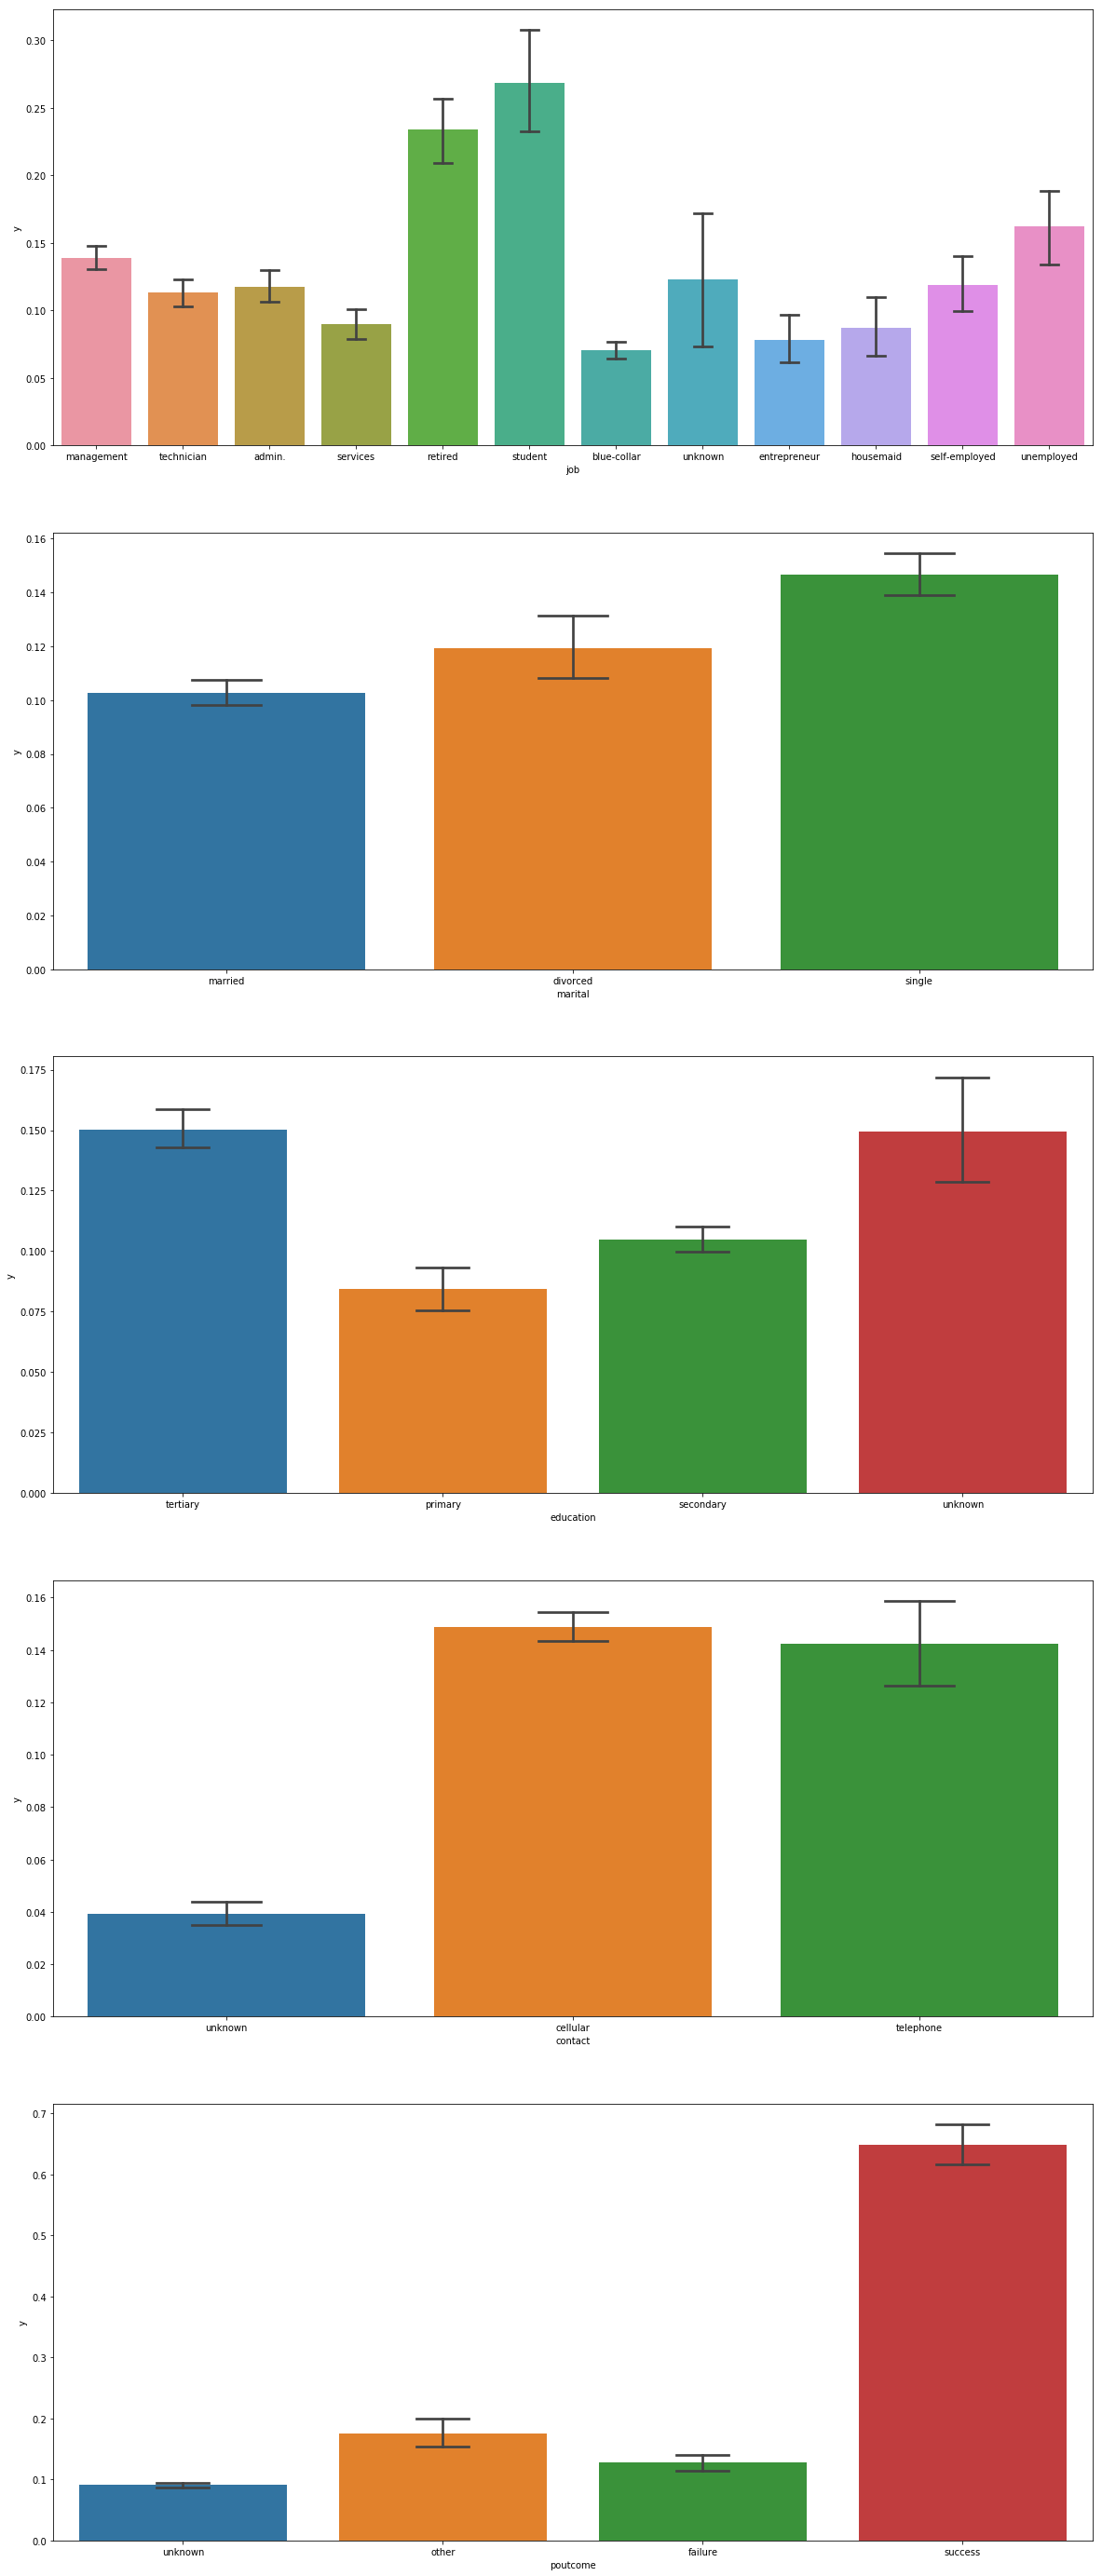

In [0]:
fig, axis = plt.subplots(5, 1, figsize=(20, 50))

sns.barplot('job', 'y', data=train_data, capsize=.2, ax=axis[0])

sns.barplot('marital', 'y', data=train_data, capsize=.2, ax=axis[1])

sns.barplot('education', 'y', data=train_data, capsize=.2, ax=axis[2])

sns.barplot('contact', 'y', data=train_data, capsize=.2, ax=axis[3])

sns.barplot('poutcome', 'y', data=train_data, capsize=.2, ax=axis[4])

In [0]:
bb = pd.pivot_table(train_data,index=["marital"],columns=["y"],values=["age"],aggfunc=np.size)
bb = bb.reset_index()
bb['ratio'] = bb['age',1] / bb['age',0]
bb

marital    age           ratio
y                0     1          
0  divorced   2567   348  0.135567
1   married  13680  1565  0.114401
2    single   6109  1048  0.171550

3、看一下数据类型对最终结果的影响程度
【客户年龄】、【每年账户的平均余额】、【最后一次联系的交流时长】、【在本次活动中，与该客户交流过的次数】、【距离上次活动最后一次联系该客户，过去了多久】、【在本次活动之前，与该客户交流过的次数】与【客户是否会订购定期存款业务】的影响程度
从结果来看，std方差大的数据，后续需要处理，例如做特征缩放或者极端值删除等
特征是连续变量时，则绘制在同一张图里的两个分布，一个表示正例比例(postive)，另一个表示负例比例(negtive)。考察两个分布的重叠区域大小（高度重叠表示该单特征对于目标的影响很弱，但还需要进一步考察该单特征会不会与其他关联特征组成强特）上述六图除了第四图（campaign）的重叠区域并不大，即对目标影响较强

In [0]:
train_data.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000
mean,40.935379,1357.555082,15.835289,257.732393,2.772050,40.248766,0.591737,0.116957
std,10.634289,2999.822811,8.319480,256.975151,3.136097,100.213541,2.568313,0.321375
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,181.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1435.000000,21.000000,317.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,3881.000000,55.000000,854.000000,275.000000,1.000000


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

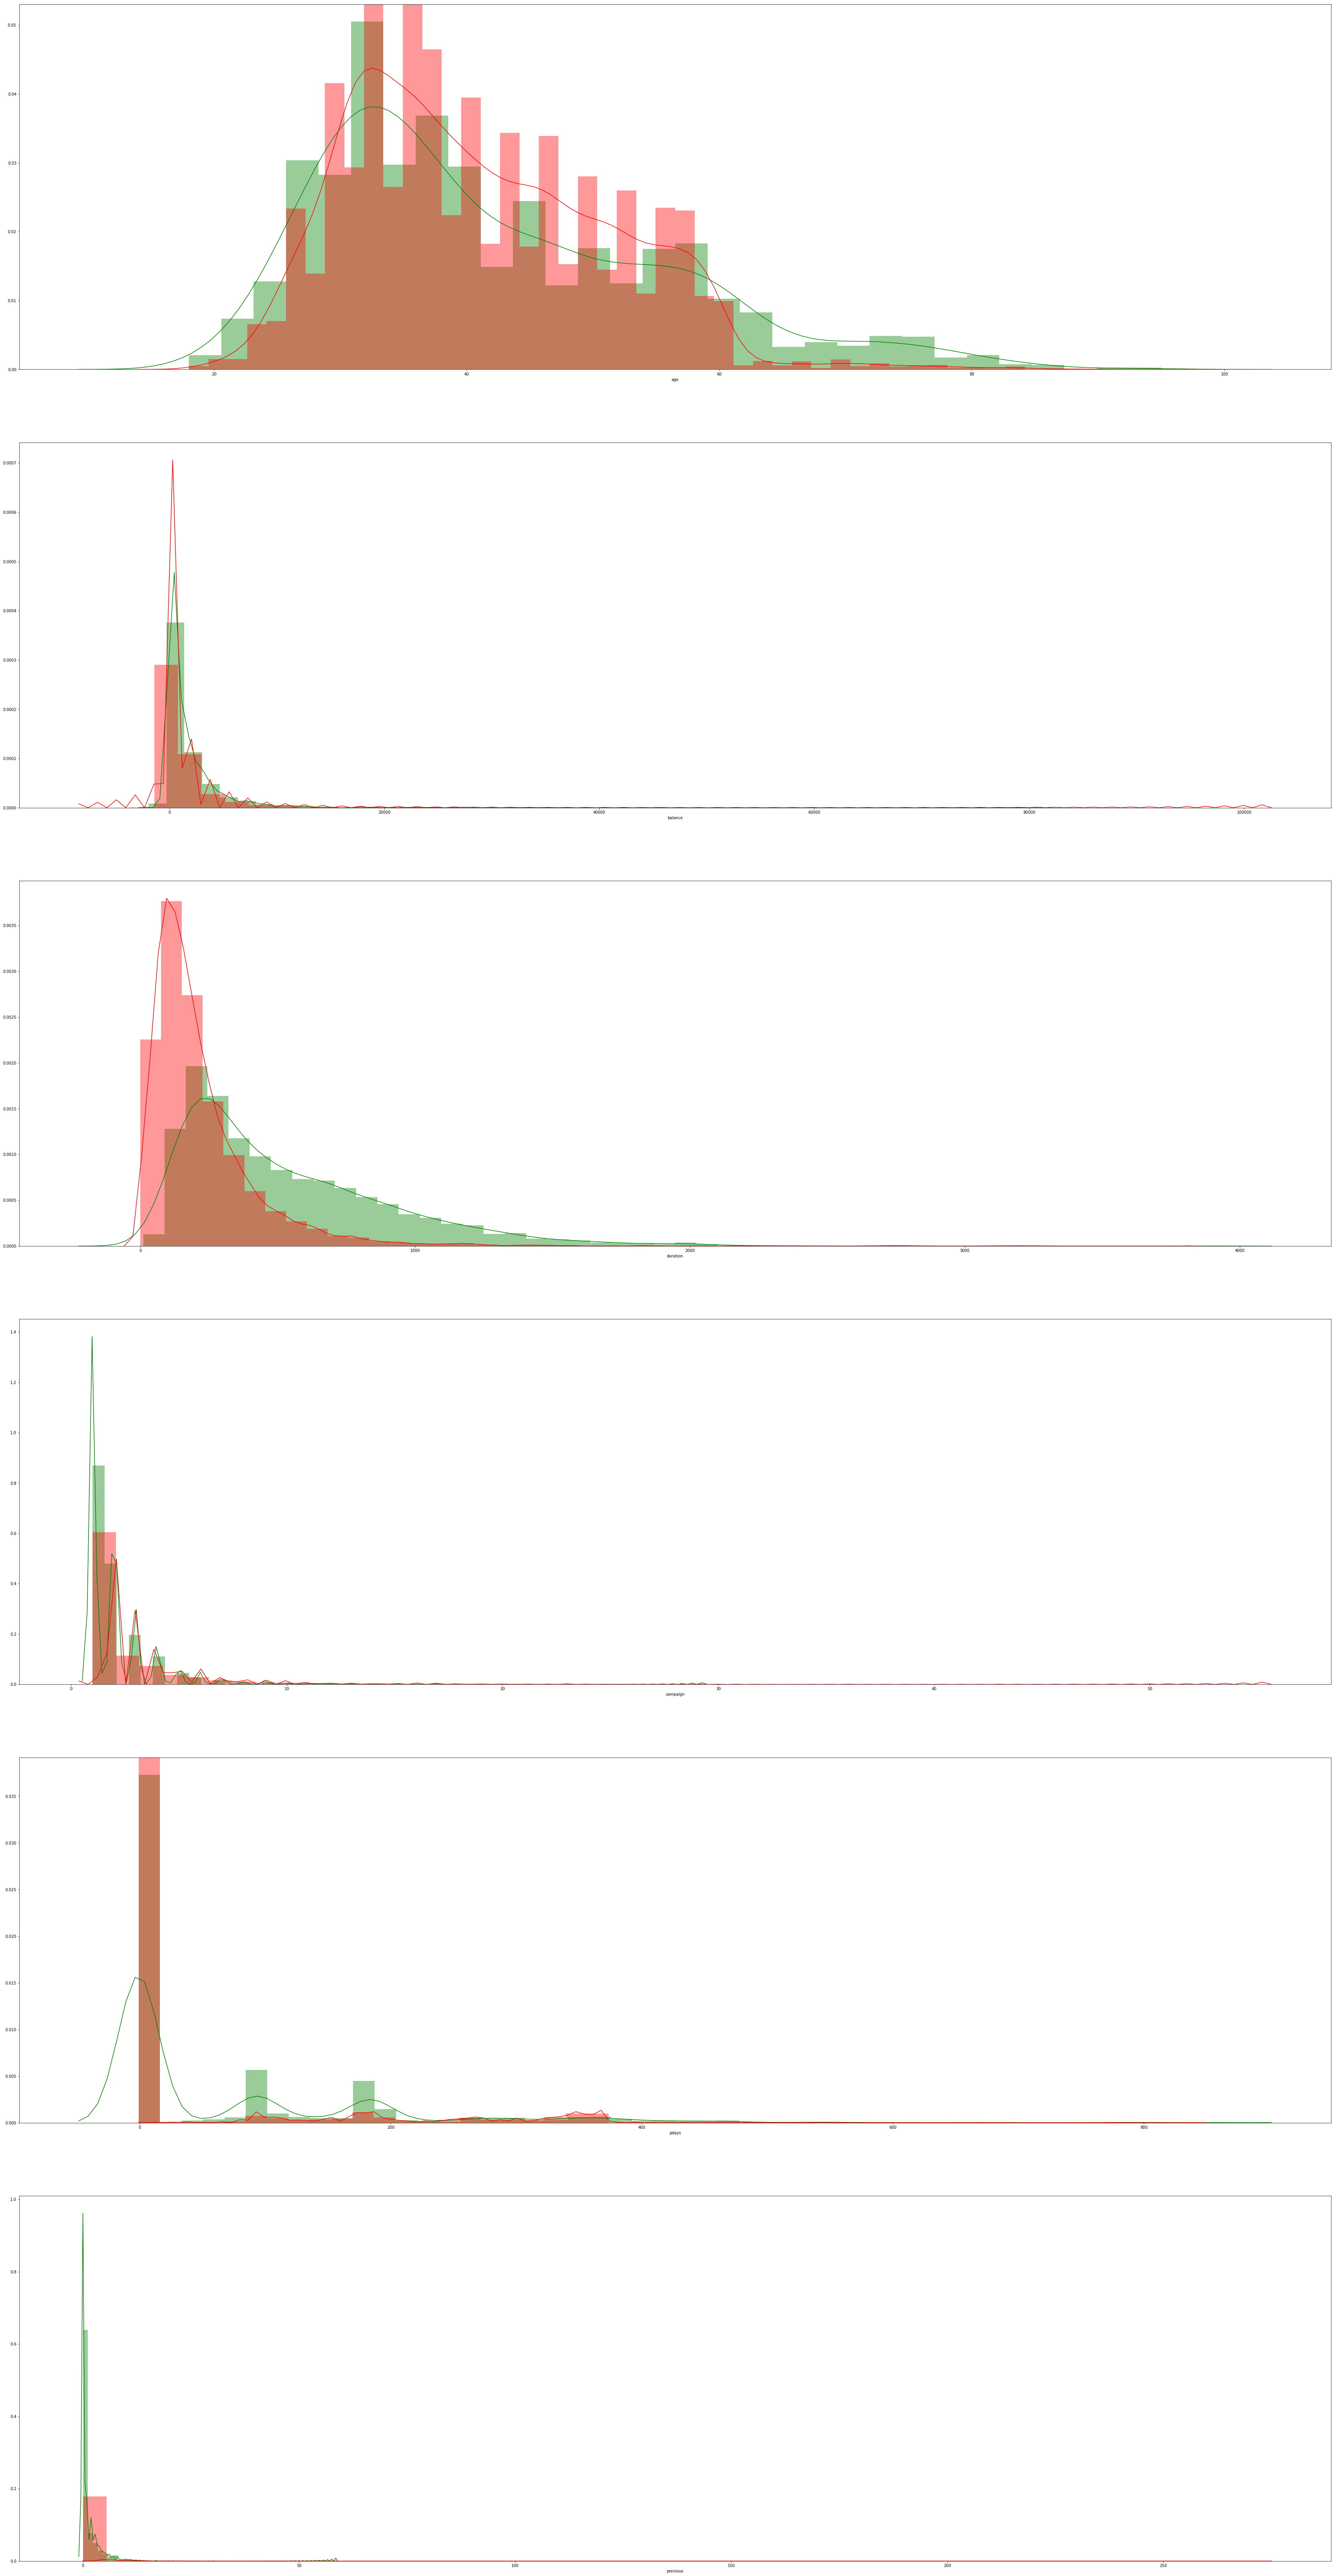

In [0]:
postive_train = train_data[train_data['y'] == 1]
negtive_train = train_data[train_data['y'] == 0]
fig, axis = plt.subplots(6, 1, figsize=(60, 120))

sns.distplot(postive_train['age'], color='g', ax=axis[0])
sns.distplot(negtive_train['age'], color='r', ax=axis[0])

sns.distplot(postive_train['balance'], color='g', ax=axis[1])
sns.distplot(negtive_train['balance'], color='r', ax=axis[1])

sns.distplot(postive_train['duration'], color='g', ax=axis[2])
sns.distplot(negtive_train['duration'], color='r', ax=axis[2])

sns.distplot(postive_train['campaign'], color='g', ax=axis[3])
sns.distplot(negtive_train['campaign'], color='r', ax=axis[3])

sns.distplot(postive_train['pdays'], color='g', ax=axis[4])
sns.distplot(negtive_train['pdays'], color='r', ax=axis[4])

sns.distplot(postive_train['previous'], color='g', ax=axis[5])
sns.distplot(negtive_train['previous'], color='r', ax=axis[5])

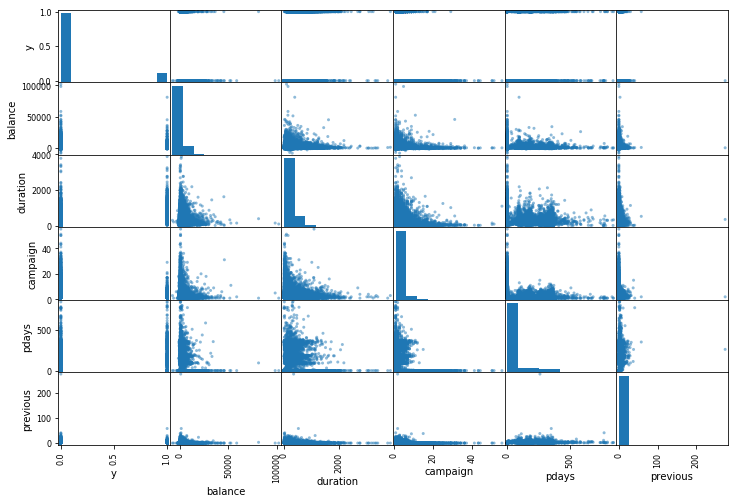

In [0]:
from pandas.plotting import scatter_matrix
attributes = ["y", "balance", "duration","campaign","pdays","previous"]
scatter_matrix(train_data[attributes], figsize=(12, 8))
plt.show()

No handles with labels found to put in legend.


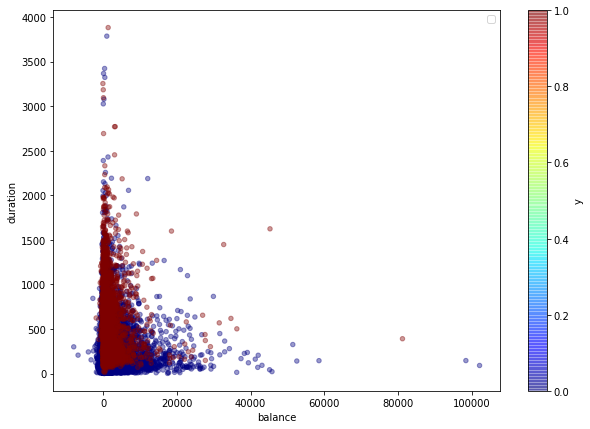

In [0]:
# 可以通过散点图对数据进行进一步的查看
# aa = train_data[train_data['y'] == 0]
train_data.plot(kind="scatter", x="balance", y="duration",alpha=0.4, figsize=(10,7),
    c="y", cmap=plt.get_cmap('jet'), colorbar=True,
    sharex=False)
plt.legend()

# 三、数据预处理

1、对所有的分类类型做one-hot

In [3]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
1,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
2,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
3,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
4,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0


In [4]:
# 将day和month去除
train_data.drop(['day'], axis=1, inplace=True)
test_data.drop(['day'], axis=1, inplace=True)
train_data.drop(['month'], axis=1, inplace=True)
test_data.drop(['month'], axis=1, inplace=True)

In [5]:
#train_data分成两个部分，一部分为训练集，一部分为测试集，拆分的原则是拆分后y的正负值比例相同
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_data, train_data["y"]):
    strat_train_set = train_data.loc[train_index]
    strat_test_set = train_data.loc[test_index]

In [6]:
# 可以验证拆分后比例的确是相同的
# strat_test_set["y"].value_counts() / len(strat_test_set)

0    0.883096
1    0.116904
Name: y, dtype: float64

In [7]:
train_x = strat_train_set.drop("y", axis=1) # drop labels for training set
train_y_labels = strat_train_set["y"].copy()
test_x = strat_test_set.drop("y", axis=1) # drop labels for training set
test_y_labels = strat_test_set["y"].copy()

In [9]:
test_x.info()
# 直接用pandas的get_dummies可以进行独热编码
# aa = pd.get_dummies(data=train_data, columns=['job'])
# aa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5064 entries, 12100 to 112
Data columns (total 14 columns):
age          5064 non-null int64
job          5064 non-null object
marital      5064 non-null object
education    5064 non-null object
default      5064 non-null object
balance      5064 non-null int64
housing      5064 non-null object
loan         5064 non-null object
contact      5064 non-null object
duration     5064 non-null int64
campaign     5064 non-null int64
pdays        5064 non-null int64
previous     5064 non-null int64
poutcome     5064 non-null object
dtypes: int64(6), object(8)
memory usage: 593.4+ KB


In [8]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
# 先将数值型的类型和文本型的类型选择出来
# num 就是中选择那些数值型的字段的dataframe
# train_x_num = train_data.drop('job', axis=1)  #选择多列
train_x_num = train_x.select_dtypes(include=[np.number]) #按照类型选择
train_x_text = train_x.select_dtypes(exclude=[np.number])

In [10]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_num_tr = num_pipeline.fit_transform(train_x_num)

In [11]:
train_num_tr[0]

array([-1.03002613, -0.32698214, -0.78866274, -0.24700095,  0.56703839,
        0.5106343 ])

In [12]:
from sklearn.preprocessing import OneHotEncoder
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer

num_attribs = list(train_x_num)
cat_attribs = list(train_x_text)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_x_prepared = full_pipeline.fit_transform(train_x)
test_x_prepared = full_pipeline.fit_transform(test_x)

In [13]:
test_x_prepared.shape

(5064, 38)

# 三、数据训练
采用GBRT梯度提升决策树进行训练

In [14]:
gbm0 = GradientBoostingClassifier(random_state=11)
gbm0.fit(train_x_prepared, train_y_labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=11, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [15]:
test_y_pred = gbm0.predict(test_x_prepared)
test_y_predprob = gbm0.predict_proba(test_x_prepared)
test_y_predprob = test_y_predprob[:, 1]

print("Accuracy : %.4g" % metrics.accuracy_score(test_y_labels, test_y_pred))
print("AUC Score (Train): %f" % metrics.roc_auc_score(test_y_labels, test_y_predprob))

train_y_pred = gbm0.predict(train_x_prepared)
train_y_predprob = gbm0.predict_proba(train_x_prepared)
train_y_predprob = train_y_predprob[:, 1]

print("Accuracy : %.4g" % metrics.accuracy_score(train_y_labels, train_y_pred))
print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y_labels, train_y_predprob))

Accuracy : 0.9019
AUC Score (Train): 0.898522
Accuracy : 0.9113
AUC Score (Train): 0.917632
